<div style="line-height:1.2;">

<h1 style="color:#BF66F2; margin-bottom: 0.3em;"> Natural Language Processing in PyTorch 2 </h1>

<h4 style="margin-top: 0.3em; margin-bottom: 1em;"> NPL from scratch. Name Classification with a Character-level RNN. </h4>

<div style="line-height:1.4; margin-bottom: 0.5em;">
    <h3 style="color: lightblue; display: inline; margin-right: 0.5em;">Keywords:</h3> Colab upload files + torch.no_grad + torch.topk + confusion matrix + ascii_letters + matshow + os.path.splitext + NLLLoss
</div>

</div>

In [1]:
import os
import time
import math
import glob
import random
import string
from io import open

import unicodedata
from google.colab import files

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# Ask user to upload a file on Colab
uploaded = files.upload()

## Read the contents of the uploaded file
file = next(iter(uploaded))
file_content = uploaded[file].decode('utf-8')

Saving Vietnamese.txt to Vietnamese.txt
Saving Spanish.txt to Spanish.txt
Saving Scottish.txt to Scottish.txt
Saving Russian.txt to Russian.txt
Saving Portuguese.txt to Portuguese.txt
Saving Polish.txt to Polish.txt
Saving Korean.txt to Korean.txt
Saving Japanese.txt to Japanese.txt
Saving Italian.txt to Italian.txt
Saving Irish.txt to Irish.txt
Saving Greek.txt to Greek.txt
Saving German.txt to German.txt
Saving French.txt to French.txt
Saving English.txt to English.txt
Saving Dutch.txt to Dutch.txt
Saving Czech.txt to Czech.txt
Saving Chinese.txt to Chinese.txt
Saving Arabic.txt to Arabic.txt


<h3 style="color:#BF66F2 "> Data preparation </h3>

In [3]:
def findFiles(path): return glob.glob(path)
print(findFiles('*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    """ Turn a Unicode string to plain ASCII. """
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c)!='Mn'
        and c in all_letters)

['Russian.txt', 'Korean.txt', 'Polish.txt', 'Japanese.txt', 'Greek.txt', 'English.txt', 'Portuguese.txt', 'French.txt', 'Scottish.txt', 'Italian.txt', 'Dutch.txt', 'Chinese.txt', 'Czech.txt', 'Irish.txt', 'Vietnamese.txt', 'German.txt', 'Spanish.txt', 'Arabic.txt']


In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

def readLines(filename):
    """ Read a file and split into lines. """
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [5]:
for filename in findFiles('*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [6]:
print(category_lines['Italian'][:25])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni', 'Abatescianni', 'Abba', 'Abbadelli', 'Abbascia', 'Abbatangelo', 'Abbatantuono', 'Abbate', 'Abbatelli', 'Abbaticchio', 'Abbiati', 'Abbracciabene', 'Abbracciabeni', 'Abelli', 'Abello', 'Abrami', 'Abramo', 'Acardi', 'Accardi', 'Accardo', 'Acciai']


<h3 style="color:#BF66F2 "> Turn Names into Tensors </h3>

In [7]:
def letterToIndex(letter):
    """ Find letter index from all_letters, e.g. "a" = 0. """
    return all_letters.find(letter)

def letterToTensor(letter):
    """ Turn a letter into a <1 x n_letters> Tensor. """
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    """ Turn a line into a <line_length x 1 x n_letters>, or an array of one-hot letter vectors. """
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [ ]:
class RNN(nn.Module):
    """ Simple Recurrent Neural Network (RNN) model for classification.

    Args:
        - Size of the input tensor [int]
        - Size of the hidden state tensor [int]
        - Size of the output tensor [int]
    
    Attributes:
        - hidden_size: The size of the hidden state tensor [int]
        - i2h: The input-to-hidden linear layer [Linear]
        - h2o: The hidden-to-output linear layer [Linear]
        - softmax: The softmax activation function for the output [LogSoftmax]

    Methods:
        forward(input, hidden): Forward pass of the RNN model.
        initHidden(): Initialize the hidden state with zeros.

    Details: 
        - RNN has two layers:
            - i2h: It represents the linear transformation from the input and hidden state to the hidden state.\\
            It is responsible for combining the input and hidden state information.
            - h2o: It represents the linear transformation from the hidden state to the output.\\
            It maps the hidden state to the output size.
    """

    def __init__(self, input_size, hidden_size, output_size):
        """ Initialize the RNN model. """
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        """ Perform the forward pass of the RNN model.

        Parameters:
            - Input [torch.Tensor]
            - Hidden state tensor of shape (batch_size, hidden_size)

        Returns:
            - Output tensor of shape (batch_size, hidden_size)
            - Updated hidden state tensor of shape (batch_size, hidden_size)
        """
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        """ Initialize the hidden state with all zeros.

        Returns:
            Zero-initialized hidden state tensor with shape 
        """
        return torch.zeros(1, self.hidden_size)

In [9]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

<h2 style="color:#BF66F2 "> <u> Example #1 </u> </h2>

In [10]:
""" Pass an input (Tensor for the current letter) and a previous hidden state (initialized as zeros at first). """
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

print("output", output)
print("next_hidden", next_hidden)

output tensor([[-2.8398, -2.9833, -2.8809, -2.9301, -2.9829, -2.8036, -2.8516, -2.8700,
         -2.8755, -2.6954, -3.0103, -2.9385, -2.8844, -2.9315, -2.8099, -2.9142,
         -2.9048, -2.9717]], grad_fn=<LogSoftmaxBackward0>)
next_hidden tensor([[ 1.1441e-01, -2.6612e-02, -9.5093e-02,  8.5117e-02,  2.3667e-02,
         -5.3453e-02,  4.7341e-02,  5.5660e-02, -6.3757e-02,  8.7814e-02,
          6.2402e-02,  3.2113e-02, -8.1227e-02,  9.4302e-02,  3.8403e-02,
          7.5839e-02,  6.4280e-02, -1.0072e-01, -3.7664e-02,  6.2196e-02,
          5.2840e-02,  2.7334e-03,  1.1538e-01, -1.3415e-04,  6.6320e-03,
          8.1819e-02, -9.1388e-02, -6.3305e-02,  9.4965e-02,  4.7899e-03,
         -1.3611e-01, -2.0180e-02,  1.2042e-01, -7.2447e-02, -2.0273e-02,
          3.5916e-03,  1.3873e-02, -7.4798e-02,  6.3361e-02,  1.0349e-01,
          8.1744e-02, -2.5596e-02, -1.9139e-02, -6.7588e-03, -5.0209e-02,
          1.9826e-02,  9.4400e-02,  3.1880e-02, -2.8161e-02, -5.5717e-02,
          8.8718e-0

<h2 style="color:#BF66F2 "> <u> Example #2 </u> </h2>

In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)

print("output:\n", output)
print("next_hidden:\n", next_hidden)

output:
 tensor([[-2.8398, -2.9833, -2.8809, -2.9301, -2.9829, -2.8036, -2.8516, -2.8700,
         -2.8755, -2.6954, -3.0103, -2.9385, -2.8844, -2.9315, -2.8099, -2.9142,
         -2.9048, -2.9717]], grad_fn=<LogSoftmaxBackward0>)
next_hidden:
 tensor([[ 1.1441e-01, -2.6612e-02, -9.5093e-02,  8.5117e-02,  2.3667e-02,
         -5.3453e-02,  4.7341e-02,  5.5660e-02, -6.3757e-02,  8.7814e-02,
          6.2402e-02,  3.2113e-02, -8.1227e-02,  9.4302e-02,  3.8403e-02,
          7.5839e-02,  6.4280e-02, -1.0072e-01, -3.7664e-02,  6.2196e-02,
          5.2840e-02,  2.7334e-03,  1.1538e-01, -1.3415e-04,  6.6320e-03,
          8.1819e-02, -9.1388e-02, -6.3305e-02,  9.4965e-02,  4.7899e-03,
         -1.3611e-01, -2.0180e-02,  1.2042e-01, -7.2447e-02, -2.0273e-02,
          3.5916e-03,  1.3873e-02, -7.4798e-02,  6.3361e-02,  1.0349e-01,
          8.1744e-02, -2.5596e-02, -1.9139e-02, -6.7588e-03, -5.0209e-02,
          1.9826e-02,  9.4400e-02,  3.1880e-02, -2.8161e-02, -5.5717e-02,
          8.871

<h3 style="color:#BF66F2 "> Prepare data for training </h3>

In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 9)


In [14]:
def randomChoice(l):
    """ Choose randomly an element from a list. """
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    """ Generate a random training example for the text classification model.
    
    Details:
        - Randomly choose a category from the list of all categories;
        - Randomly choose a line of text from the corresponding category;
        - Convert the category into a tensor using the index of the category in the all_categories list;
        - Convert the line of text into a tensor using the lineToTensor function;
        - Return a tuple containing the category, line of text, category tensor, and line tensor;
    
    Returns:
        - Category
        - Line of text
        - Category tensor
        - Line tensor.
    """
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [15]:
""" Generate 10 random training examples and print out the category and line of text for each example. """
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = French / line = Comtois
category = Dutch / line = Kann
category = German / line = Bayer
category = Japanese / line = Aihara
category = English / line = Down
category = Japanese / line = Shimamura
category = Russian / line = Jdanovich
category = Russian / line = Matzko
category = Italian / line = Nicotera
category = Italian / line = Arrigucci


<h3 style="color:#BF66F2 "> Train the Network </h3>

**Note:** <br>
The "nn.NLLLoss" (Negative Log-Likelihood Loss) is chosen since we are doing a classification problem and the last layer of the RNN is nn.LogSoftmax. <br>

The "nn.LogSoftmax" layer takes the output of the previous linear layer and applies the logarithm and softmax functions to it, <br>
which produces a probability distribution over the categories. <br>
The "nn.NLLLoss()" method is designed to work with logarithmic probabilities, which makes it a suitable loss function for the nn.LogSoftmax layer.


In [16]:
""" The criterion variable is used to define the loss function for the RNN model. """
criterion = nn.NLLLoss()

In [17]:
""" Learning_rate should not be set too high neither to slow, it might explode or it might not learn. """
learning_rate = 0.005

In [19]:
def train(category_tensor, line_tensor):
    """ Trains the RNN model on a single training example.
    
    Parameters:
        -The tensor representing the category of the training example.
        -The tensor representing the line of text of the training example.
    Details:
        - Initialize the hidden state tensor
        - Set the gradients of all model parameters to zero
        - Iterate over each character in the line of text
            - Compute the output and update the hidden state tensor
        - Compute the loss between the output and the target category
        - Compute the gradients of the loss with respect to the model parameters
        - Update the model parameters by adding the gradients multiplied by the learning rate
        - Return the output tensor and the loss value as a tuple

    Returns:
        Output tensor + loss value
    """
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # Compute the loss 
    loss = criterion(output, category_tensor)
    # Compute the gradients
    loss.backward()

    # Update parameters 
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [20]:
""" Train the RNN model on a single training example. """
output, loss = train(category_tensor, line_tensor)

In [21]:
n_iters = 100000
print_every = 5000
plot_every = 1000

## Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [22]:
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (0m 6s) 2.7918 Kang / Chinese ✗ (Korean)
10000 10% (0m 13s) 3.0427 Shige / Vietnamese ✗ (Japanese)
15000 15% (0m 19s) 1.4603 Rypka / Polish ✗ (Czech)
20000 20% (0m 26s) 1.9430 Tsogas / Arabic ✗ (Greek)
25000 25% (0m 32s) 2.1783 Halevin / Irish ✗ (Russian)
30000 30% (0m 39s) 1.4597 White / Scottish ✓
35000 35% (0m 45s) 1.1656 Ma / Korean ✓
40000 40% (0m 51s) 1.0011 Tomori / Japanese ✓
45000 45% (0m 57s) 1.3273 She / Korean ✗ (Chinese)
50000 50% (1m 4s) 2.4420 Hagan / Irish ✗ (English)
55000 55% (1m 10s) 1.4209 Gaffney / English ✓
60000 60% (1m 17s) 0.4170 Ravenna / Italian ✓
65000 65% (1m 23s) 0.4395 Le / Vietnamese ✓
70000 70% (1m 30s) 0.6276 Black / Scottish ✓
75000 75% (1m 36s) 2.3928 Dubicki / Japanese ✗ (Polish)
80000 80% (1m 42s) 1.2668 Penner / Dutch ✓
85000 85% (1m 48s) 1.6291 Gonzalez / Polish ✗ (Spanish)
90000 90% (1m 55s) 0.0412 Iwasaki / Japanese ✓
95000 95% (2m 1s) 0.0134 Batsakis / Greek ✓
100000 100% (2m 8s) 0.0366 Mikolajczak / Polish ✓


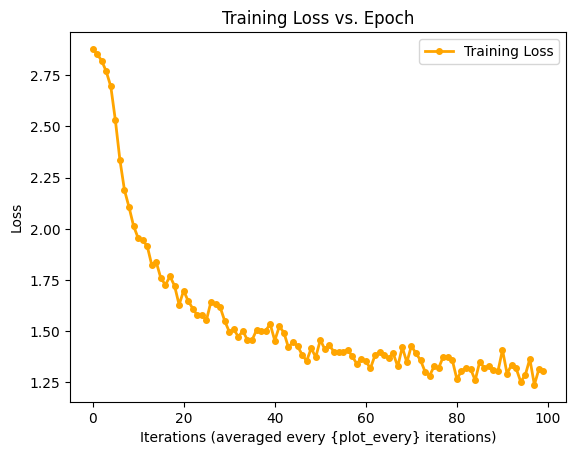

In [42]:
#plt.figure()
#plt.plot(all_losses);

plt.plot(all_losses, label='Training Loss', color='orange', linestyle='-', linewidth=2, marker='o', markersize=4);
plt.xlabel('Iterations (averaged every {plot_every} iterations)')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend();
plt.show()

<h3 style="color:#BF66F2 "> Metrics: Evaluate results </h3>

In [25]:
## Confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    """ Evaluate and return the output, given a line. """
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

<ipython-input-26-ab4641c5c526>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-26-ab4641c5c526>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


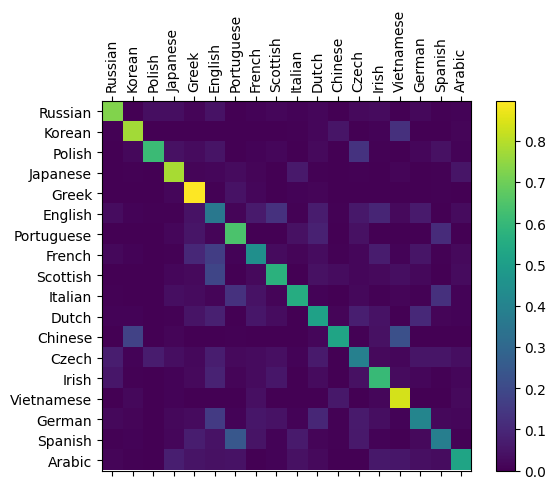

In [26]:
""" Go through a bunch of examples and record which are correctly guessed """

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

##### Set up plot characteristics
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

## Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)
## Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

<h3 style="color:#BF66F2 "> => Main: Run on User Input </h3>

In [ ]:
def predict(input_line, n_predictions=3):
    """ Predict the category of an input line and print the top N predictions.

    Parameters :
        - Input line to predict the category for [str]
        - Number of top predictions to print [int]

    Returns:
        List of top predictions, each containing the prediction value and category
    """
    # Print the input line
    print('\n> %s' % input_line)  
    # Disable gradient calculation 
    with torch.no_grad():  
        # Convert the input line to a tensor and evaluate the output
        output = evaluate(lineToTensor(input_line))  
        # Get the top N values and indices from the output tensor
            # "topk" returns the k largest elements of the given input tensor along a given dimension.
        topv, topi = output.topk(n_predictions, 1, True)  
        predictions = []

        for i in range(n_predictions):  
            value = topv[0][i].item()  
            category_index = topi[0][i].item()  
            print('(%.2f) %s' % (value, all_categories[category_index]))  
            # Add the prediction value and category index to the predictions list
            predictions.append([value, all_categories[category_index]])  

        return predictions

In [30]:
predict('Raul')
predict('James')
predict('Lin')
predict('Giacomo')


> Raul
(-1.09) Irish
(-2.13) French
(-2.25) Scottish

> James
(-1.45) English
(-1.74) German
(-1.93) Dutch

> Lin
(-0.96) Chinese
(-1.76) Vietnamese
(-2.21) Korean

> Giacomo
(-0.17) Italian
(-2.32) Spanish
(-3.39) Portuguese
